# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install scikit-learn --upgrade

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (0.24.1)


In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data_transform import data_transform

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

import pickle

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# magic word for producing visualizations in notebook
%matplotlib inline
sns.set_style()

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
%%time
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', nrows=600e3)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [ ]:
azdias.info(null_counts=True, verbose=True)

In [ ]:
customers.info(null_counts=True, verbose=True)

Along with the datasets the company provided two .xlxs files with the data dictionary. Looking into those files two things were extracted

* One file which contained the name of the data file column, which type of variable it was (id, categorical, ordinal, binary, numeric or not found), and finally an action to keep or to drop. a column was categorized as not found if it's description was not present in any of the data dictionary.

* Information about the codification of null values, most of the fields are labeled as 0 or -1, when they were null. this is important because in the next steps the amount of missing values will be measured in order to discard columns.

this iformation is very important to the development of the model, this information is used inside data_transform/data_transform.py

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [4]:
print("number of columns before cleaning {}:".format(azdias.shape[1]))

number of columns before cleaning 366:


Now a transformation/extraction process is made to the following columns
* CAMEO_DEUG_2015: values will be transformed to float and non numeric values to NaN
* OST_WEST_KZ: make it binary making O (east)=0 and W(west)=1
* PLZ8_BAUMAX: create a column PLZ8_BAUMAX_FAMILY_BUSINESS to show if the building is for business 1 or not 0
* PRAEGENDE_JUGENDJAHRE:  divide into two columns 

>   PRAEGENDE_JUGENDJAHRE_DECADE
 1: 40 ies
 2: 50 ies
 3: 60 ies
 4: 70 ies
 5: 80 ies
 6: 90 ies
 
> PRAEGENDE_JUGENDJAHRE_MOVEMENT
 1: Mainstream
 0: Avantgrade 
 
* WOHNLAGE:  generate a new column from WOHNLAGE column, thet indicates whether the building is in the city (1), rural (2) or no score (0)

Start cleaning data
success: replacing AGER_TYP column keys to Nan
success: replacing ALTERSKATEGORIE_GROB column keys to Nan
success: replacing ALTER_HH column keys to Nan
success: replacing ANREDE_KZ column keys to Nan
success: replacing BALLRAUM column keys to Nan
success: replacing BIP_FLAG column keys to Nan
success: replacing CAMEO_DEUG_2015 column keys to Nan
success: replacing CAMEO_DEUINTL_2015 column keys to Nan
success: replacing CJT_GESAMTTYP column keys to Nan
success: replacing D19_BANKEN_ANZ_12 column keys to Nan
success: replacing D19_BANKEN_ANZ_24 column keys to Nan
success: replacing D19_BANKEN_DATUM column keys to Nan
success: replacing D19_BANKEN_DIREKT_ column keys to Nan
success: replacing D19_BANKEN_GROSS_ column keys to Nan
success: replacing D19_BANKEN_LOKAL_ column keys to Nan
success: replacing D19_BANKEN_OFFLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_QUOTE_12 column keys to 

success: replacing KBA05_MAXAH column keys to Nan
success: replacing KBA13_MAXAH column keys to Nan
success: replacing KBA05_MAXBJ column keys to Nan
success: replacing KBA13_MAXBJ column keys to Nan
success: replacing KBA05_MAXHERST column keys to Nan
success: replacing KBA13_MAXHERST column keys to Nan
success: replacing KBA05_MAXSEG column keys to Nan
success: replacing KBA13_MAXSEG column keys to Nan
success: replacing KBA05_MAXVORB column keys to Nan
success: replacing KBA13_MAXVORB column keys to Nan
success: replacing KBA05_MOD1 column keys to Nan
success: replacing KBA13_MOD1 column keys to Nan
success: replacing KBA05_MOD2 column keys to Nan
success: replacing KBA13_MOD2 column keys to Nan
success: replacing KBA05_MOD3 column keys to Nan
success: replacing KBA13_MOD3 column keys to Nan
success: replacing KBA05_MOD4 column keys to Nan
success: replacing KBA13_MOD4 column keys to Nan
success: replacing KBA05_MOD8 column keys to Nan
success: replacing KBA13_MOD8 column keys to Na

success: replacing KBA13_SEG_MINIWAGEN column keys to Nan
success: replacing KBA13_SEG_MITTELKLASSE column keys to Nan
success: replacing KBA13_SEG_OBEREMITTELKLASSE column keys to Nan
success: replacing KBA13_SEG_OBERKLASSE column keys to Nan
success: replacing KBA13_SEG_SONSTIGE column keys to Nan
success: replacing KBA13_SEG_SPORTWAGEN column keys to Nan
success: replacing KBA13_SEG_UTILITIES column keys to Nan
success: replacing KBA13_SEG_VAN column keys to Nan
success: replacing KBA13_SEG_WOHNMOBILE column keys to Nan
success: replacing KBA13_SITZE_4 column keys to Nan
success: replacing KBA13_SITZE_5 column keys to Nan
success: replacing KBA13_SITZE_6 column keys to Nan
success: replacing KBA13_TOYOTA column keys to Nan
success: replacing KBA13_VORB_0 column keys to Nan
success: replacing KBA13_VORB_1 column keys to Nan
success: replacing KBA13_VORB_1_2 column keys to Nan
success: replacing KBA13_VORB_2 column keys to Nan
success: replacing KBA13_VORB_3 column keys to Nan
success

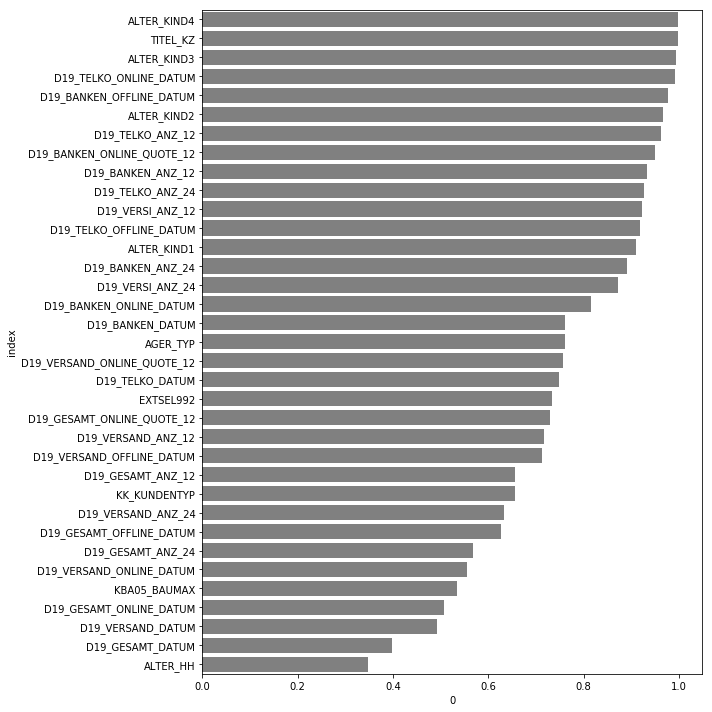

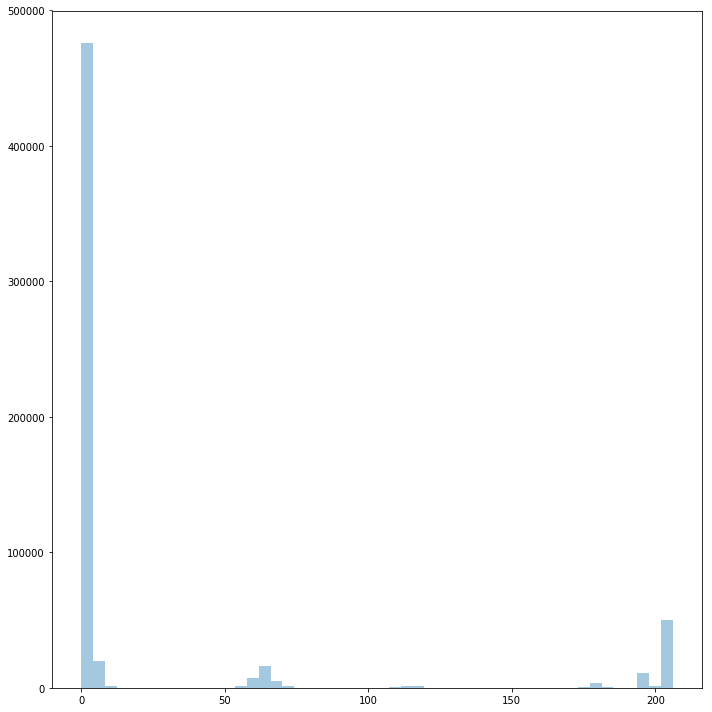

In [5]:
%%time
azdias = data_transform.clean_transform_data(azdias, train= True)

In [6]:
print("number of columns after cleaning {}:".format(azdias.shape[1]))

number of columns after cleaning 274:


In [7]:
#Load information about what to do wit columns keep or drop
df_col_actions = data_transform.load_col_actions(azdias)

Section to show the behaviour of GEBURTSJAHR data, to justify the custom dealing of null values

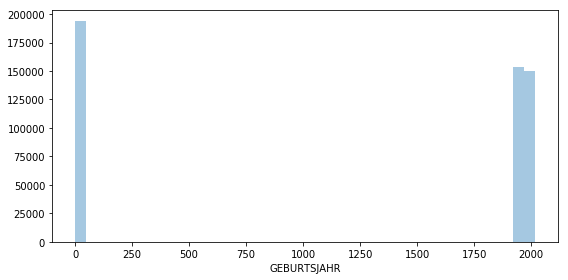

In [8]:
fig,ax = plt.subplots(figsize=(8,4))
sns.distplot(azdias['GEBURTSJAHR'],kde=False)
fig.tight_layout()
fig.savefig("Images/GEBURTSJAHR_dist_before_transformation.png")

Perform Custom null handling

Now a custom transformer is fit and applied to the data, the actions performed by it are:
- Fill the column D19_LOTTO with 0
- Fill all the categorical and ordinal columns with the value -1
- make a GEBURTSJAHR approximation, by getting the average year at each PRAEGENDE_JUGENDJAHRE_DECADE, then filling that average for those who have a PRAEGENDE_JUGENDJAHRE_DECADE; if they do not have fill with the mean over GEBURTSJAHR

In [7]:
%%time
dnt = data_transform.data_null_transform()

CPU times: user 12 µs, sys: 20 µs, total: 32 µs
Wall time: 36.7 µs


In [10]:
%%time
dnt.fit(azdias)
azdias_transform = dnt.transform(azdias)

CPU times: user 2.28 s, sys: 11.4 s, total: 13.7 s
Wall time: 1min 7s


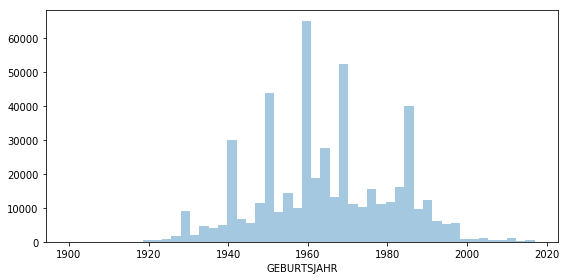

In [11]:
fig,ax = plt.subplots(figsize=(8,4))
c3 = azdias['GEBURTSJAHR'].isna()
sns.distplot(azdias_transform.loc[~c3,'GEBURTSJAHR'],kde=False)
fig.tight_layout()
fig.savefig("Images/GEBURTSJAHR_dist_after_transformation.png")

* Check for percentage of null values in each column category 

In [19]:
len(df_col_actions)
c0 = df_col_actions['CATEGORY'] == 'categorical'
for col in df_col_actions.loc[c0,'COLUMN']:
    print(col)
    null_val = azdias[col].isna().mean()
    print(null_val)
    if null_val > 0.1:
        display(azdias[col].value_counts(normalize=True))
    print()

BALLRAUM
0.0006338193956783578

CAMEO_DEUG_2015
0.004390456893238656

CJT_GESAMTTYP
0.006002169070820766

D19_BANKEN_DIREKT
0.0

D19_BANKEN_GROSS
0.0

D19_BANKEN_LOKAL
0.0

D19_BANKEN_REST
0.0

D19_BEKLEIDUNG_GEH
0.0

D19_BEKLEIDUNG_REST
0.0

D19_BILDUNG
0.0

D19_BIO_OEKO
0.0

D19_DIGIT_SERV
0.0

D19_DROGERIEARTIKEL
0.0

D19_ENERGIE
0.0

D19_FREIZEIT
0.0

D19_GARTEN
0.0

D19_HANDWERK
0.0

D19_HAUS_DEKO
0.0

D19_KINDERARTIKEL
0.0

D19_KONSUMTYP
0.2221748254984537


9.0    0.405371
1.0    0.181704
4.0    0.122948
6.0    0.087568
3.0    0.085708
2.0    0.078224
5.0    0.038477
Name: D19_KONSUMTYP, dtype: float64


D19_KOSMETIK
0.0

D19_LEBENSMITTEL
0.0

D19_LOTTO
0.2221748254984537


0.0    0.767581
7.0    0.184459
6.0    0.041780
5.0    0.003063
3.0    0.002848
4.0    0.000137
2.0    0.000111
1.0    0.000021
Name: D19_LOTTO, dtype: float64


D19_NAHRUNGSERGAENZUNG
0.0

D19_RATGEBER
0.0

D19_REISEN
0.0

D19_SAMMELARTIKEL
0.0

D19_SCHUHE
0.0

D19_SONSTIGE
0.0

D19_TECHNIK
0.0

D19_TELKO_MOBILE
0.0

D19_TELKO_REST
0.0

D19_TIERARTIKEL
0.0

D19_VERSAND_REST
0.0

D19_VERSICHERUNGEN
0.0

D19_VOLLSORTIMENT
0.0

D19_WEIN_FEINKOST
0.0

EWDICHTE
0.0006338193956783578

FINANZTYP
0.0

GEBAEUDETYP
0.0

GEBAEUDETYP_RASTER
1.0060625328227901e-05

GFK_URLAUBERTYP
0.006002169070820766

KBA05_MAXHERST
0.0

KBA05_MAXSEG
0.0

KBA05_MAXVORB
0.0

KBA05_MOTOR
0.0

KBA13_BAUMAX
0.0

KONSUMNAEHE
6.640012716630415e-05

LP_FAMILIE_GROB
0.006002169070820766

LP_LEBENSPHASE_GROB
0.006002169070820766

LP_STATUS_GROB
0.006002169070820766

NATIONALITAET_KZ
0.04275363339483729

OST_WEST_KZ
0.0

PLZ8_BAUMAX
0.004792881906367772

RETOURTYP_BK_S
0.006002169070820766

SHOPPER_TYP
0.04625875525919189

VERS_TYP
0.04625875525919189

WOHNLAGE
0.0

ZABEOTYP
0.0

ANREDE_KZ
0.0

ALTERSKATEGORIE_GROB
0.0

PRAEGENDE_JUGENDJAHRE_MOVEMENT
0.028755279313140987

PLZ8_BAU

In [20]:
len(df_col_actions)
c0 = df_col_actions['CATEGORY'] == 'ordinal'
for col in df_col_actions.loc[c0,'COLUMN']:
    print(col)
    null_val = azdias[col].isna().mean()
    print(null_val)
    if null_val > 0:
        display(azdias[col].value_counts(normalize=True))
    print()

FINANZ_ANLEGER
0.0

FINANZ_HAUSBAUER
0.0

FINANZ_MINIMALIST
0.0

FINANZ_SPARER
0.0

FINANZ_UNAUFFAELLIGER
0.0

FINANZ_VORSORGER
0.0

HEALTH_TYP
0.04625875525919189


3.0    0.417258
2.0    0.381747
1.0    0.200995
Name: HEALTH_TYP, dtype: float64


HH_EINKOMMEN_SCORE
0.0

INNENSTADT
0.0006338193956783578


5.0    0.184210
4.0    0.169631
6.0    0.139088
2.0    0.137088
3.0    0.118160
8.0    0.102514
7.0    0.084599
1.0    0.064709
Name: INNENSTADT, dtype: float64


KBA05_ALTER1
0.0

KBA05_ALTER2
0.0

KBA05_ALTER3
0.0

KBA05_ALTER4
0.0

KBA05_ANHANG
0.0

KBA05_ANTG1
0.0

KBA05_ANTG2
0.0

KBA05_ANTG3
0.0

KBA05_ANTG4
0.0

KBA05_AUTOQUOT
8.04850026258232e-06


3.0    0.348537
4.0    0.262929
2.0    0.165273
1.0    0.111678
5.0    0.111583
Name: KBA05_AUTOQUOT, dtype: float64


KBA05_CCM1
0.0

KBA05_CCM2
0.0

KBA05_CCM3
0.0

KBA05_CCM4
0.0

KBA05_DIESEL
0.0

KBA05_FRAU
0.0

KBA05_GBZ
0.0

KBA05_HERST1
0.0

KBA05_HERST2
0.0

KBA05_HERST3
0.0

KBA05_HERST4
0.0

KBA05_HERST5
0.0

KBA05_HERSTTEMP
0.004933730660962963


3.0    0.371007
1.0    0.220098
2.0    0.215028
4.0    0.158041
5.0    0.035826
Name: KBA05_HERSTTEMP, dtype: float64


KBA05_KRSAQUOT
0.0

KBA05_KRSHERST1
0.0

KBA05_KRSHERST2
0.0

KBA05_KRSHERST3
0.0

KBA05_KRSKLEIN
0.0

KBA05_KRSOBER
0.0

KBA05_KRSVAN
0.0

KBA05_KRSZUL
0.0

KBA05_KW1
0.0

KBA05_KW2
0.0

KBA05_KW3
0.0

KBA05_MAXAH
0.0

KBA05_MAXBJ
0.0

KBA05_MOD1
0.0

KBA05_MOD2
0.0

KBA05_MOD3
0.0

KBA05_MOD4
0.0

KBA05_MOD8
0.0

KBA05_MODTEMP
0.0

KBA05_MOTRAD
0.0

KBA05_SEG1
0.0

KBA05_SEG10
0.0

KBA05_SEG2
0.0

KBA05_SEG3
0.0

KBA05_SEG4
0.0

KBA05_SEG5
0.0

KBA05_SEG6
0.0

KBA05_SEG7
0.0

KBA05_SEG8
0.0

KBA05_SEG9
0.0

KBA05_VORB0
0.0

KBA05_VORB1
0.0

KBA05_VORB2
0.0

KBA05_ZUL1
0.0

KBA05_ZUL2
0.0

KBA05_ZUL3
0.0

KBA05_ZUL4
0.0

KBA13_ALTERHALTER_30
0.0

KBA13_ALTERHALTER_45
0.0

KBA13_ALTERHALTER_60
0.0

KBA13_ALTERHALTER_61
0.0

KBA13_AUDI
0.0

KBA13_AUTOQUOTE
0.0

KBA13_BJ_1999
0.0

KBA13_BJ_2000
0.0

KBA13_BJ_2004
0.0

KBA13_BJ_2006
0.0

KBA13_BJ_2008
0.0

KBA13_BJ_2009
0.0

KBA13_BMW
0.0

KBA13_CCM_0_1400
0.0

KBA13_CCM_1000
0.0

KBA13_CCM_1200
0.0

KBA13_CCM_1400
0.0

KBA13_CCM_1500
0.

4.0    0.195456
3.0    0.194634
1.0    0.189901
2.0    0.183804
5.0    0.158359
0.0    0.077846
Name: ONLINE_AFFINITAET, dtype: float64


ORTSGR_KLS9
0.005211403920022053


5.0    0.187871
4.0    0.144801
7.0    0.130834
9.0    0.115203
3.0    0.103880
6.0    0.096886
8.0    0.093241
2.0    0.078152
1.0    0.049133
Name: ORTSGR_KLS9, dtype: float64


PLZ8_ANTG1
0.004792881906367772


2.0    0.350425
3.0    0.285733
1.0    0.243962
4.0    0.112912
0.0    0.006967
Name: PLZ8_ANTG1, dtype: float64


PLZ8_ANTG2
0.004792881906367772


3.0    0.399745
2.0    0.274862
4.0    0.249892
1.0    0.066227
0.0    0.009274
Name: PLZ8_ANTG2, dtype: float64


PLZ8_ANTG3
0.004792881906367772


2.0    0.329483
1.0    0.306948
3.0    0.212663
0.0    0.150906
Name: PLZ8_ANTG3, dtype: float64


PLZ8_ANTG4
0.004792881906367772


0.0    0.457355
1.0    0.384723
2.0    0.157922
Name: PLZ8_ANTG4, dtype: float64


PLZ8_GBZ
0.004792881906367772


3.0    0.372847
4.0    0.233827
5.0    0.197182
2.0    0.144449
1.0    0.051696
Name: PLZ8_GBZ, dtype: float64


PLZ8_HHZ
0.004792881906367772


3.0    0.402410
4.0    0.273819
5.0    0.226348
2.0    0.084061
1.0    0.013362
Name: PLZ8_HHZ, dtype: float64


RELAT_AB
0.005332131423960788


3.0    0.344801
5.0    0.224428
1.0    0.176760
2.0    0.131344
4.0    0.122667
Name: RELAT_AB, dtype: float64


SEMIO_DOM
0.0

SEMIO_ERL
0.0

SEMIO_FAM
0.0

SEMIO_KAEM
0.0

SEMIO_KRIT
0.0

SEMIO_KULT
0.0

SEMIO_LUST
0.0

SEMIO_MAT
0.0

SEMIO_PFLICHT
0.0

SEMIO_RAT
0.0

SEMIO_REL
0.0

SEMIO_SOZ
0.0

SEMIO_TRADV
0.0

SEMIO_VERT
0.0

W_KEIT_KIND_HH
0.07337616476889737


6.0    0.382644
4.0    0.180385
3.0    0.128055
2.0    0.113226
1.0    0.106093
5.0    0.089597
Name: W_KEIT_KIND_HH, dtype: float64


WOHNDAUER_2008
0.0

PRAEGENDE_JUGENDJAHRE_DECADE
0.028755279313140987


6.0    0.288674
4.0    0.228295
5.0    0.193646
3.0    0.154010
2.0    0.099027
1.0    0.036348
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: float64

In [23]:
len(df_col_actions)
c0 = df_col_actions['CATEGORY'] == 'binary'
for col in df_col_actions.loc[c0,'COLUMN']:
    print(col)
    null_val = azdias[col].isna().mean()
    print(null_val)
    print()

GREEN_AVANTGARDE
0.0



ANZ_HAUSHALTE_AKTIV


count    496987.000000
mean          8.160085
std          15.093002
min           0.000000
25%           2.000000
50%           4.000000
75%           9.000000
max         536.000000
Name: ANZ_HAUSHALTE_AKTIV, dtype: float64

skew:8.622337473728813
0.0

ANZ_HH_TITEL


count    496987.000000
mean          8.681841
std         130.032211
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1965.000000
Name: ANZ_HH_TITEL, dtype: float64

skew:14.978380947461158
0.0

ANZ_PERSONEN


count    496987.000000
mean          1.740657
std           1.164334
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          37.000000
Name: ANZ_PERSONEN, dtype: float64

skew:1.7080180101526952
0.0

ANZ_TITEL


count    496987.000000
mean          0.004105
std           0.067845
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: ANZ_TITEL, dtype: float64

skew:18.142506042974162
0.0

GEBURTSJAHR


count    496987.000000
mean       1964.565365
std          16.932564
min        1900.000000
25%        1951.000000
50%        1964.000000
75%        1977.000000
max        2017.000000
Name: GEBURTSJAHR, dtype: float64

skew:0.025018218194978153
0.0

KBA13_ANZAHL_PKW


count    496987.000000
mean        619.546250
std         337.659158
min           0.000000
25%         385.000000
50%         549.000000
75%         776.000000
max        2300.000000
Name: KBA13_ANZAHL_PKW, dtype: float64

skew:1.2645878564104551
0.0

MIN_GEBAEUDEJAHR


count    496987.000000
mean       1992.702338
std           1.814087
min        1985.000000
25%        1992.000000
50%        1992.000000
75%        1992.000000
max        2005.000000
Name: MIN_GEBAEUDEJAHR, dtype: float64

skew:3.0734685715007894
0.0



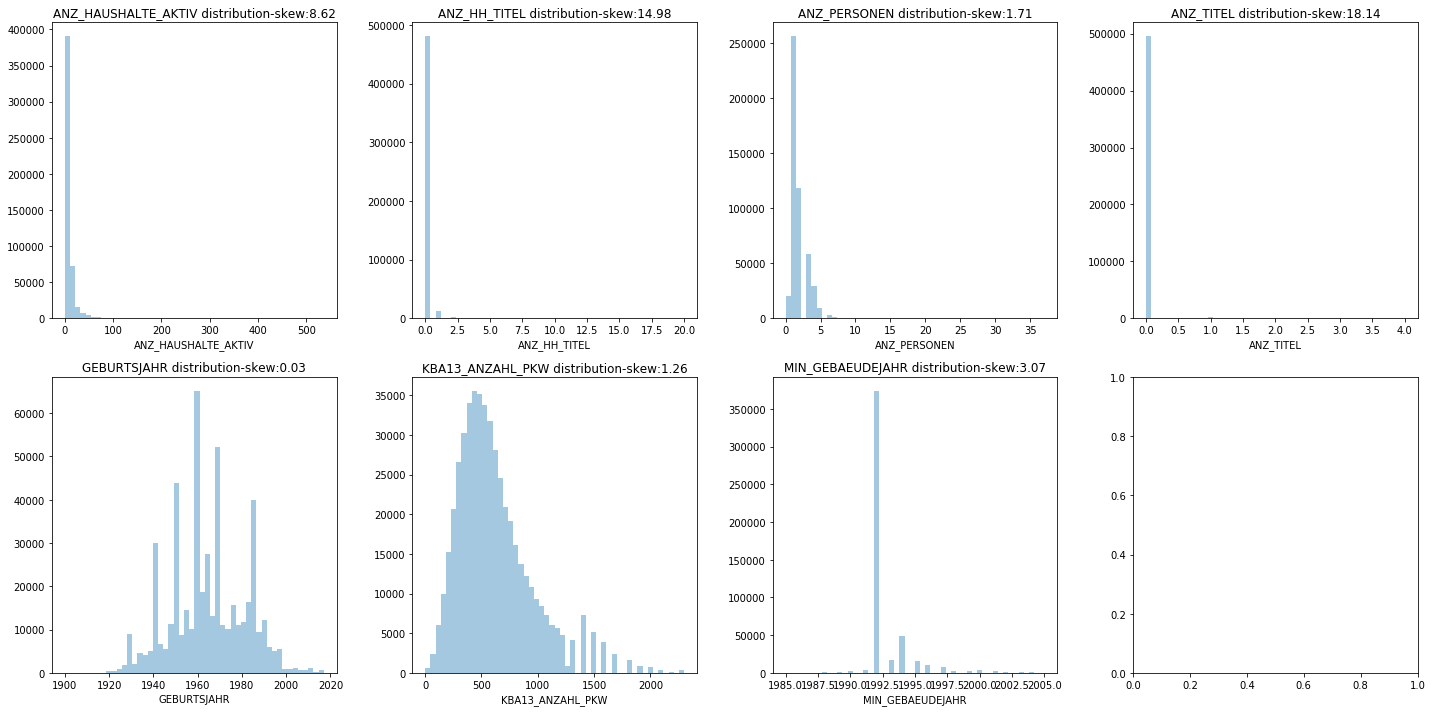

In [40]:
len(df_col_actions)
c0 = df_col_actions['CATEGORY'] == 'numeric'

fig,ax = plt.subplots(2,4,figsize=(20,10))

axes = ax.flatten()
for i, col in enumerate(df_col_actions.loc[c0,'COLUMN']):
    print(col)
    null_val = azdias_transform[col].isna().mean()
    display(azdias_transform[col].describe())
    print("skew:{}".format(azdias_transform[col].skew()))
    try:
        c0 = azdias[col].isna()
        sns.distplot(azdias_transform.loc[~c0,col], kde=False, ax=axes[i])
        axes[i].set_title("{} distribution-skew:{}".format(col,azdias_transform[col].skew().round(2)))
    except:
        continue
    print(null_val)
    print()

fig.tight_layout()
fig.savefig("Images/numeric_cols_dist.png")

In [112]:
# Check-point
# azdias_transform.to_csv('data_transform/azdias_transform.dsv',index=False,sep='|')
azdias_transform = pd.read_csv('data_transform/azdias_transform.dsv',sep='|')

# Pipeline
Even though the previous step handled some null values special cases, it is necessary to perform another null value handling, standardization and transformation,

In [12]:
df_col_actions = data_transform.load_col_actions(azdias)

In [13]:
# categorical
categorical_pipeline = Pipeline([('cat_onehot',OneHotEncoder(handle_unknown='ignore', drop=None))])

c0 = df_col_actions['CATEGORY'] == 'categorical'
categorical_columns = [x for x in df_col_actions.loc[c0,'COLUMN']]

In [14]:
# binary
binary_pipeline = Pipeline([('binary_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

c0 = df_col_actions['CATEGORY'] == 'binary'
binary_columns = [x for x in df_col_actions.loc[c0,'COLUMN']]

In [15]:
# Ordinal
ordinal_pipeline = Pipeline([('ordinal_impute',SimpleImputer(missing_values= np.nan, strategy='most_frequent')),
                             ('ordinal_standarize',StandardScaler())])

c0 = df_col_actions['CATEGORY'] == 'ordinal'
ordinal_columns = [x for x in df_col_actions.loc[c0,'COLUMN']]

In [16]:
# Numerical 
'''
    solve for the skewed data apply logarithm x+1

    impute values
    scale values 
'''
#GEBURTSJAHR
num_cols = ['GEBURTSJAHR'] # do not apply log to this column
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
num_scale = ('num_scale', StandardScaler())

num_pipeline = Pipeline(steps=[num_impute, num_scale])


c0 = df_col_actions['CATEGORY'] == 'numeric'

log_cols = [x for x in df_col_actions.loc[c0,'COLUMN'].values if x not in num_cols]
log_transform = ('log_transform', FunctionTransformer(func = np.log1p, inverse_func=np.expm1, validate=False))
log_impute = ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
log_scale = ('log_scale', StandardScaler())

log_pipeline = Pipeline(steps=[log_transform,
                              log_impute,
                              log_scale])

numeric_pipeline = ColumnTransformer(transformers=[
    ('log',log_pipeline,log_cols),
    ('num',num_pipeline,num_cols)
])


c0 = df_col_actions['CATEGORY'] == 'numeric'
numeric_columns = [x for x in df_col_actions.loc[c0,'COLUMN'].values]

In [17]:
transformers = [('categorical',categorical_pipeline,categorical_columns),
               ('binary',binary_pipeline,binary_columns),
               ('ordinal',ordinal_pipeline,ordinal_columns),
               ('numerical',numeric_pipeline,numeric_columns)
               ]

ct = ColumnTransformer(transformers=transformers)

In [18]:
%%time
print(azdias_transform.shape)
azdias_transformed = ct.fit_transform(azdias_transform)
print(azdias_transformed.shape)

(496987, 274)
(496987, 656)
CPU times: user 12.3 s, sys: 27.3 s, total: 39.6 s
Wall time: 7min 31s


In [19]:
#Check point
pl = ct.named_transformers_['categorical']
cd = pl.named_steps['cat_onehot']
dummies_names = list(cd.get_feature_names())

#all columns for transformed data
column_names = dummies_names+list(binary_columns)+list(ordinal_columns)+list(numeric_columns)
azdias_transformed = pd.DataFrame(azdias_transformed, columns = column_names)
pd.DataFrame(column_names).to_csv('data_transform/column_names.dsv',index=False,sep='|')

In [21]:
#azdias_transformed.to_csv('data_transform/azdias_transformed.dsv',index=False,sep='|')
azdias_transformed = pd.read_csv('data_transform/azdias_transformed.dsv',sep='|')

In [20]:
azdias_transformed[numeric_columns].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
count,4.969870e+05,4.969870e+05,4.969870e+05,4.969870e+05,4.969870e+05,4.969870e+05,4.969870e+05
mean,-3.771551e-16,1.491035e-16,6.253512e-17,1.589827e-17,-1.868562e-15,-1.543180e-12,-4.940074e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.896163e+00,-1.635548e-01,-2.414664e+00,-6.161792e-02,-1.115006e+01,-4.259556e+00,-3.813092e+00
25%,-6.819245e-01,-1.635548e-01,-6.169024e-01,-6.161792e-02,-5.825428e-01,-3.873122e-01,-8.011414e-01
50%,-1.173358e-01,-1.635548e-01,-6.169024e-01,-6.161792e-02,4.570745e-02,-3.873122e-01,-3.338924e-02
75%,6.487633e-01,-1.635548e-01,4.347207e-01,-6.161792e-02,6.587716e-01,-3.873122e-01,7.343630e-01
max,5.051420e+00,2.145207e+01,7.019858e+00,3.570235e+01,2.585070e+00,6.768051e+00,3.096677e+00


# PCA Dimensionality Reduction

Since now there is a large amount of columns a dimensionality reduction technique (PCA) will be used, First we must determine an appropiate amount of principal components for this we fit and the data and plot the explained variance vs number of components.

In [49]:
print("Current number of features: ", azdias_transformed.shape[1])

Current number of features:  656


In [50]:
%%time
pca = PCA()
azdias_pca = pca.fit_transform(azdias_transformed)

CPU times: user 14min 59s, sys: 2min 11s, total: 17min 10s
Wall time: 1h 50min 19s


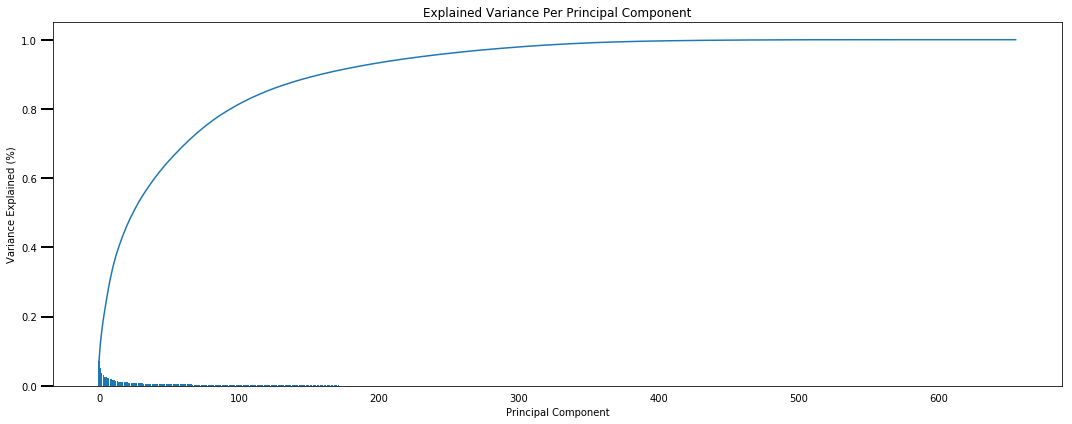

In [51]:
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(15, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')


fig.tight_layout()
fig.savefig("Images/PCA_component_variance_graph.png")

In [52]:
n_components = 158 
print("Explained variance ratio for the first {} components is {}%.".
      format(n_components, sum(pca.explained_variance_ratio_[:n_components]).round(2)*100))

Explained variance ratio for the first 158 components is 90.0%.


In [26]:
%%time
n_components = 158 
pca = PCA(n_components)
azdias_pca = pca.fit_transform(azdias_transformed)
explained_var_ratio = sum(pca.explained_variance_ratio_)
print("Explained variance ratio for the first {} components is {}%.".format(explained_var_ratio))

CPU times: user 2min 37s, sys: 2min 47s, total: 5min 24s
Wall time: 30min 5s


In [24]:
%%time
# Checkpoint
# pd.DataFrame(azdias_pca).to_csv('data_transform/azdias_pca.dsv',index=False,sep='|')
azdias_pca = pd.read_csv('data_transform/azdias_pca.dsv',sep='|')

CPU times: user 29.3 s, sys: 9.17 s, total: 38.5 s
Wall time: 1min 52s


In [27]:
# Map weights for the third principal component to corresponding feature names
component = 0

for i in np.arange(5):
    
    feature_weights = data_transform.pca_to_features(pca, i, column_names)
    print("{} component variance:{}".format(i, pca.explained_variance_ratio_[i].round(2)*100))
    print("top five positive weight features and top five features with negative weights ")
    print(feature_weights[:5])
    print(feature_weights[-5:])
    print()

0 component variance:7.000000000000001
top five positive weight features and top five features with negative weights 
                             weight
KBA13_HERST_BMW_BENZ           0.15
KBA13_MERCEDES                 0.14
KBA05_HERST1                   0.13
KBA13_SEG_OBEREMITTELKLASSE    0.12
KBA13_BMW                      0.12
                         weight
KBA13_SEG_KOMPAKTKLASSE   -0.13
KBA13_SEG_KLEINWAGEN      -0.13
KBA13_KW_0_60             -0.13
KBA13_SITZE_5             -0.13
HH_EINKOMMEN_SCORE        -0.13

1 component variance:5.0
top five positive weight features and top five features with negative weights 
                      weight
MOBI_REGIO              0.20
KBA13_ALTERHALTER_60    0.19
KBA13_AUTOQUOTE         0.18
KBA13_HALTER_55         0.18
KBA05_GBZ               0.18
                             weight
HH_EINKOMMEN_SCORE            -0.12
KBA05_ANTG4                   -0.13
KBA13_SEG_OBEREMITTELKLASSE   -0.13
KBA13_HERST_BMW_BENZ          -0.13
ANZ_HAUSHALTE_A

# Kmeans clustering

for customer segmentation a KMeans algorithm is applied. in order to find the best k the elbow method is used, for this step a MiniBatchKMeans is used since it reduces the computation time, and it will be useful to find the best parameter.

In [ ]:
# find the better k number

batch_size=40000

scores = []
centers = list(range(1,31, 1))
for center in centers:
    print(center)
    kmeans = MiniBatchKMeans(n_clusters=center, batch_size=batch_size, random_state=42).fit(azdias_pca)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(azdias_pca)

    # Obtain a score related to the model fit
    score = np.abs(model.score(azdias_pca))
    scores.append(score)   


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [ ]:
# number of k vs scores

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K using MiniBatchKMeans');
plt.savefig("Images/Kmeans_elbow.png")

In [ ]:
d = np.subtract(scores[0:len(scores)-1],scores[1:len(scores)])

plt.plot(centers[:len(scores)-1], d, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('Change in SSE vs. K using MiniBatchKMeans');
plt.savefig("Images/Kmeans_shift_diff.png")

### Selection of parameters

by the previous steps we see the change in the Average of sum of squared errors (SSE) and choose 15 as the best K for our segmentation.

In [29]:
%%time
n_clusters = 15
km = KMeans(n_clusters=n_clusters, random_state=42)

km.fit(azdias_pca)

CPU times: user 4min 43s, sys: 0 ns, total: 4min 43s
Wall time: 4min 53s


In [ ]:
general_predictions = km.predict(azdias_pca)
general_predictions[:20]

# Final Pipeline

A single pipeline is made. with 
* PCA components = 158 
* n_clusters for Kmeans = 15

In [7]:
dnt = data_transform.data_null_transform()

In [8]:
df_col_actions = data_transform.load_col_actions(azdias)

# categorical
categorical_pipeline = Pipeline([('cat_onehot',OneHotEncoder(handle_unknown='ignore', drop=None))])

c0 = df_col_actions['CATEGORY'] == 'categorical'
categorical_columns = [x for x in df_col_actions.loc[c0,'COLUMN']]

# binary
binary_pipeline = Pipeline([('binary_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

c0 = df_col_actions['CATEGORY'] == 'binary'
binary_columns = [x for x in df_col_actions.loc[c0,'COLUMN']]

# Ordinal
ordinal_pipeline = Pipeline([('ordinal_impute',SimpleImputer(missing_values= np.nan, strategy='most_frequent')),
                             ('ordinal_standarize',StandardScaler())])

c0 = df_col_actions['CATEGORY'] == 'ordinal'
ordinal_columns = [x for x in df_col_actions.loc[c0,'COLUMN']]

# Numerical 
'''
    solve for the skewed data apply logarithm x+1

    impute values
    scale values 
'''
#GEBURTSJAHR
num_cols = ['GEBURTSJAHR'] # do not apply log to this column
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
num_scale = ('num_scale', StandardScaler())

num_pipeline = Pipeline(steps=[num_impute, num_scale])


c0 = df_col_actions['CATEGORY'] == 'numeric'

log_cols = [x for x in df_col_actions.loc[c0,'COLUMN'].values if x not in num_cols]
log_transform = ('log_transform', FunctionTransformer(func = np.log1p, inverse_func=np.expm1, validate=False))
log_impute = ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
log_scale = ('log_scale', StandardScaler())

log_pipeline = Pipeline(steps=[log_transform,
                              log_impute,
                              log_scale])

numeric_pipeline = ColumnTransformer(transformers=[
    ('log',log_pipeline,log_cols),
    ('num',num_pipeline,num_cols)
])


c0 = df_col_actions['CATEGORY'] == 'numeric'
numeric_columns = [x for x in df_col_actions.loc[c0,'COLUMN'].values]

transformers = [('categorical',categorical_pipeline,categorical_columns),
               ('binary',binary_pipeline,binary_columns),
               ('ordinal',ordinal_pipeline,ordinal_columns),
               ('numerical',numeric_pipeline,numeric_columns)
               ]

ct = ColumnTransformer(transformers=transformers)

In [9]:
n_components = 158
n_clusters = 15

cluster_pipeline = Pipeline([
                        ('null',dnt),
                        ('transform', ct), 
                        ('pca', PCA(n_components,random_state=42)),
                        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42) )
                        ])

In [10]:
%%time
cluster_pipeline.fit(azdias)

CPU times: user 6min 34s, sys: 3min 38s, total: 10min 13s
Wall time: 35min 50s


Pipeline(steps=[('null', data_null_transform()),
                ('transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('cat_onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BALLRAUM',
                                                   'CAMEO_DEUG_2015',
                                                   'CJT_GESAMTTYP',
                                                   'D19_BANKEN_DIREKT',
                                                   'D19_BANKEN_GROSS',
                                                   'D19_BANKEN_LOKAL',
                                                   'D19_BANKEN_REST',
                                                   'D19_BEKLEIDUNG_GEH',
                                                   'D19_BEKLEIDUNG_REST',
                                 

In [11]:
%%time
train_preds =  cluster_pipeline.predict(azdias)
train_preds[:10]

CPU times: user 16.4 s, sys: 1min 3s, total: 1min 20s
Wall time: 16min 15s


* Save or load the trained model

In [12]:
# Save pickle
# pkl_filename = "Model/unsupervised_cluster_model.pkl"  
# with open(pkl_filename, 'wb') as file:  
#     pickle.dump(cluster_pipeline, file)

In [3]:
# Read pickle
pkl_filename = "Model/unsupervised_cluster_model.pkl"  
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file)
    
cluster_pipeline = pickle_model

## Population preds
* If the model is loaded, excecute the following cells to create the necessary data to perform the following analysis

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


Start cleaning data
success: replacing AGER_TYP column keys to Nan
success: replacing ALTERSKATEGORIE_GROB column keys to Nan
success: replacing ALTER_HH column keys to Nan
success: replacing ANREDE_KZ column keys to Nan
success: replacing BALLRAUM column keys to Nan
success: replacing BIP_FLAG column keys to Nan
success: replacing CAMEO_DEUG_2015 column keys to Nan
success: replacing CAMEO_DEUINTL_2015 column keys to Nan
success: replacing CJT_GESAMTTYP column keys to Nan
success: replacing D19_BANKEN_ANZ_12 column keys to Nan
success: replacing D19_BANKEN_ANZ_24 column keys to Nan
success: replacing D19_BANKEN_DATUM column keys to Nan
success: replacing D19_BANKEN_DIREKT_ column keys to Nan
success: replacing D19_BANKEN_GROSS_ column keys to Nan
success: replacing D19_BANKEN_LOKAL_ column keys to Nan
success: replacing D19_BANKEN_OFFLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_QUOTE_12 column keys to 

success: replacing KBA13_MAXVORB column keys to Nan
success: replacing KBA05_MOD1 column keys to Nan
success: replacing KBA13_MOD1 column keys to Nan
success: replacing KBA05_MOD2 column keys to Nan
success: replacing KBA13_MOD2 column keys to Nan
success: replacing KBA05_MOD3 column keys to Nan
success: replacing KBA13_MOD3 column keys to Nan
success: replacing KBA05_MOD4 column keys to Nan
success: replacing KBA13_MOD4 column keys to Nan
success: replacing KBA05_MOD8 column keys to Nan
success: replacing KBA13_MOD8 column keys to Nan
success: replacing KBA05_MODTEMP column keys to Nan
success: replacing KBA13_MODTEMP column keys to Nan
success: replacing KBA05_MOTOR column keys to Nan
success: replacing KBA13_MOTOR column keys to Nan
success: replacing KBA05_MOTRAD column keys to Nan
success: replacing KBA13_MOTRAD column keys to Nan
success: replacing KBA05_SEG1 column keys to Nan
success: replacing KBA13_SEG1 column keys to Nan
success: replacing KBA05_SEG10 column keys to Nan
succ

success: replacing ORTSGR_KLS9 column keys to Nan
success: replacing OST_WEST_KZ column keys to Nan
success: replacing PLZ8_ANTG1 column keys to Nan
success: replacing PLZ8_ANTG2 column keys to Nan
success: replacing PLZ8_ANTG3 column keys to Nan
success: replacing PLZ8_ANTG4 column keys to Nan
success: replacing PLZ8_GBZ column keys to Nan
success: replacing PLZ8_HHZ column keys to Nan
success: replacing PRAEGENDE_JUGENDJAHRE column keys to Nan
success: replacing REGIOTYP column keys to Nan
success: replacing RELAT_AB column keys to Nan
success: replacing RETOURTYP_BK_S column keys to Nan
success: replacing SEMIO_DOM column keys to Nan
success: replacing SEMIO_ERL column keys to Nan
success: replacing SEMIO_FAM column keys to Nan
success: replacing SEMIO_KAEM column keys to Nan
success: replacing SEMIO_KRIT column keys to Nan
success: replacing SEMIO_KULT column keys to Nan
success: replacing SEMIO_LUST column keys to Nan
success: replacing SEMIO_MAT column keys to Nan
success: replac

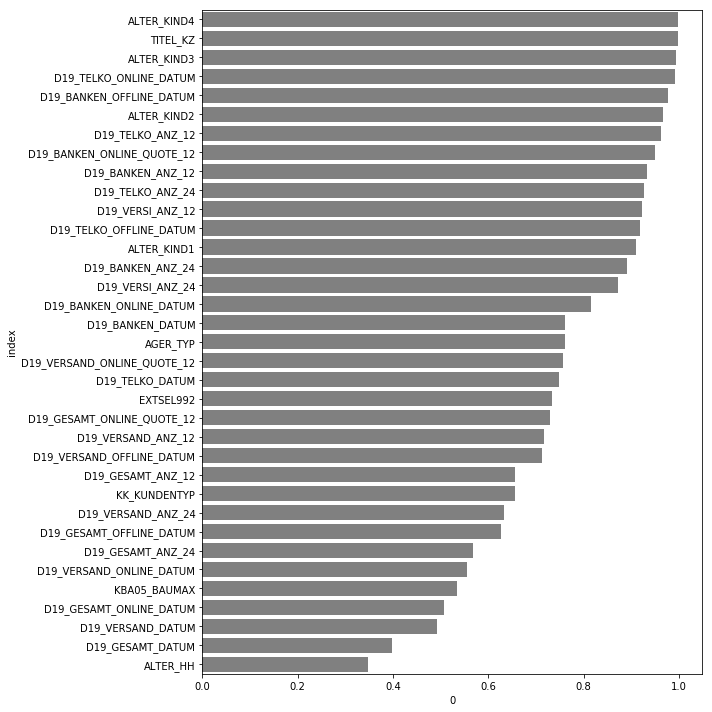

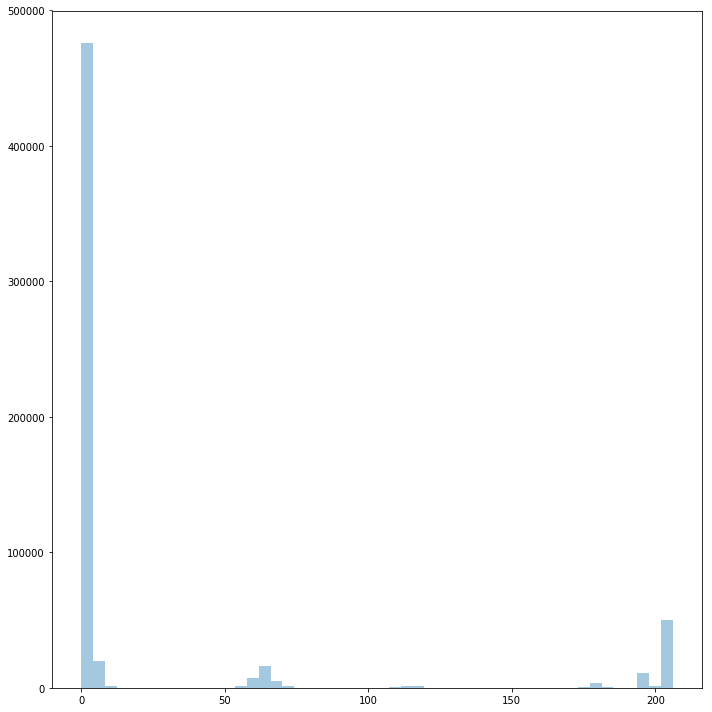

In [4]:
%%time
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', nrows=600e3)
azdias = data_transform.clean_transform_data(azdias, train= True)

In [14]:
%%time
train_preds =  cluster_pipeline.predict(azdias)

CPU times: user 17.1 s, sys: 1min 7s, total: 1min 24s
Wall time: 17min 38s


# Customer Preds

In [15]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
%%time
customers = data_transform.clean_transform_data(customers, train= False)

Start cleaning data
success: replacing AGER_TYP column keys to Nan
success: replacing ALTERSKATEGORIE_GROB column keys to Nan
success: replacing ALTER_HH column keys to Nan
success: replacing ANREDE_KZ column keys to Nan
success: replacing BALLRAUM column keys to Nan
success: replacing BIP_FLAG column keys to Nan
success: replacing CAMEO_DEUG_2015 column keys to Nan
success: replacing CAMEO_DEUINTL_2015 column keys to Nan
success: replacing CJT_GESAMTTYP column keys to Nan
success: replacing D19_BANKEN_ANZ_12 column keys to Nan
success: replacing D19_BANKEN_ANZ_24 column keys to Nan
success: replacing D19_BANKEN_DATUM column keys to Nan
success: replacing D19_BANKEN_DIREKT_ column keys to Nan
success: replacing D19_BANKEN_GROSS_ column keys to Nan
success: replacing D19_BANKEN_LOKAL_ column keys to Nan
success: replacing D19_BANKEN_OFFLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_QUOTE_12 column keys to 

success: replacing KBA05_MAXSEG column keys to Nan
success: replacing KBA13_MAXSEG column keys to Nan
success: replacing KBA05_MAXVORB column keys to Nan
success: replacing KBA13_MAXVORB column keys to Nan
success: replacing KBA05_MOD1 column keys to Nan
success: replacing KBA13_MOD1 column keys to Nan
success: replacing KBA05_MOD2 column keys to Nan
success: replacing KBA13_MOD2 column keys to Nan
success: replacing KBA05_MOD3 column keys to Nan
success: replacing KBA13_MOD3 column keys to Nan
success: replacing KBA05_MOD4 column keys to Nan
success: replacing KBA13_MOD4 column keys to Nan
success: replacing KBA05_MOD8 column keys to Nan
success: replacing KBA13_MOD8 column keys to Nan
success: replacing KBA05_MODTEMP column keys to Nan
success: replacing KBA13_MODTEMP column keys to Nan
success: replacing KBA05_MOTOR column keys to Nan
success: replacing KBA13_MOTOR column keys to Nan
success: replacing KBA05_MOTRAD column keys to Nan
success: replacing KBA13_MOTRAD column keys to Na

success: replacing KKK column keys to Nan
success: replacing NATIONALITAET_KZ column keys to Nan
success: replacing ORTSGR_KLS9 column keys to Nan
success: replacing OST_WEST_KZ column keys to Nan
success: replacing PLZ8_ANTG1 column keys to Nan
success: replacing PLZ8_ANTG2 column keys to Nan
success: replacing PLZ8_ANTG3 column keys to Nan
success: replacing PLZ8_ANTG4 column keys to Nan
success: replacing PLZ8_GBZ column keys to Nan
success: replacing PLZ8_HHZ column keys to Nan
success: replacing PRAEGENDE_JUGENDJAHRE column keys to Nan
success: replacing REGIOTYP column keys to Nan
success: replacing RELAT_AB column keys to Nan
success: replacing RETOURTYP_BK_S column keys to Nan
success: replacing SEMIO_DOM column keys to Nan
success: replacing SEMIO_ERL column keys to Nan
success: replacing SEMIO_FAM column keys to Nan
success: replacing SEMIO_KAEM column keys to Nan
success: replacing SEMIO_KRIT column keys to Nan
success: replacing SEMIO_KULT column keys to Nan
success: replac

In [17]:
%%time
customers_predictions = cluster_pipeline.predict(customers)
customers_predictions[:20]

CPU times: user 5.19 s, sys: 8.86 s, total: 14 s
Wall time: 1min 12s


# Comparing Clusters

Now that a classification model exists, we apply it to both of the interest population, the general population and the customers, Then we see the proportion of customers in each group.

In [19]:
df_customer_preds = pd.DataFrame(customers_predictions)
df_train_preds = pd.DataFrame(train_preds)

print("length of customer {}".format(len(df_customer_preds)))
print("length of training {}".format(len(df_train_preds)))

length of customer 191652
length of training 496987


In [20]:
df_customer_preds[0].value_counts(normalize=True, sort= False).reset_index().T

,index,0
0,0,0.003026
1,1,0.006950
2,2,0.120479
3,3,0.045019
4,4,0.016786
5,5,0.123943
6,6,0.201835
7,7,0.018758
8,8,0.068880
9,9,0.030858


Plot the proportion of customers that belong to each cluster

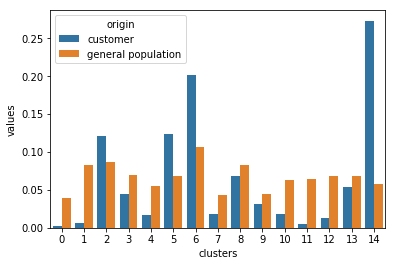

In [21]:
a = df_customer_preds[0].value_counts(normalize=True, sort= False).reset_index()
a['origin'] = 'customer'
b = df_train_preds[0].value_counts(normalize=True, sort=False).reset_index()
b['origin'] = 'general population'
df_clusters = pd.concat([a, b], ignore_index= True)

df_clusters.columns = ['clusters','values','origin']

sns_fig = sns.barplot(data=df_clusters, x= 'clusters', y= 'values', hue= 'origin')
fig = sns_fig.get_figure()
fig.savefig("Images/pecentage_people_customer_general_population.png")

Plot the difference in proportions between the two main population, substract <b> General Population </b> from <b> Customers </b>

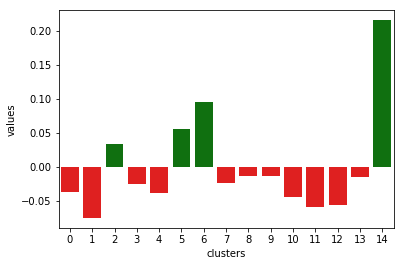

In [22]:
clusters_diff = a[['index',0]].copy()
clusters_diff.columns = ['clusters','values']
clusters_diff['values'] -= b[0]
clusters_diff['less'] = 0
c0 = clusters_diff['values'] < 0 
clusters_diff.loc[c0, 'less'] = 1

colors = ['r' if x < 0 else 'g' for x in clusters_diff['values']]

sns_fig = sns.barplot(data=clusters_diff, x= 'clusters', y= 'values', palette=colors)
fig = sns_fig.get_figure()
fig.savefig("Images/difference_pecentage_people_kmeans_groups.png")

in the graph we identify two main classes of clusters

high % customer
> - 14
> - 6

low % customer
> - 1
> - 11

In [23]:
pl = ct.named_transformers_['categorical']
cd = pl.named_steps['cat_onehot']
dummies_names = list(cd.get_feature_names())
column_names = dummies_names+list(binary_columns)+list(ordinal_columns)+list(numeric_columns)
# pd.DataFrame(column_names).to_csv('data_transform/column_names.dsv',index=False,sep='|')
column_names = list(pd.read_csv('data_transform/column_names.dsv',sep='|').T.values[0])

* Now we go backwards in the transformation process in order to be able to analyze the characteristics of the people that belongs to clusters indentifed before

In [24]:
# Get all the transformers to go backwards

stp_kmeans = cluster_pipeline['kmeans']
stp_pca = cluster_pipeline['pca']
stp_transform = cluster_pipeline['transform']
stp_null = cluster_pipeline['null']

cluster_centers = stp_pca.inverse_transform(stp_kmeans.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns= column_names)

stp_categorical = stp_transform.named_transformers_['categorical']
stp_binary = stp_transform.named_transformers_['binary']
stp_ordinal = stp_transform.named_transformers_['ordinal']['ordinal_standarize']

stp_numerical = stp_transform.named_transformers_['numerical']
stp_log = stp_numerical.named_transformers_['log']
stp_log_transform = stp_numerical.named_transformers_['log']['log_transform']
stp_log_scale = stp_numerical.named_transformers_['log']['log_scale']
stp_numeric = stp_numerical.named_transformers_['num']['num_scale']

# Column definitions
dummy_categorical_cols = stp_categorical['cat_onehot'].get_feature_names()
categorical_cols = stp_transform.transformers_[0][2]
binary_cols = stp_transform.transformers_[1][2]
ordinal_cols = stp_transform.transformers_[2][2]
numerical_cols = stp_transform.transformers_[3][2]
log_columns = stp_numerical.transformers_[0][2]
numeric_columns = stp_numerical.transformers_[1][2]

In [25]:
# Apply inverse transformations
stp_categorical.inverse_transform(cluster_centers[dummy_categorical_cols]).shape

cluster_centers[numeric_columns] = stp_numeric.inverse_transform(cluster_centers[numeric_columns])
cluster_centers[log_columns] = stp_log_scale.inverse_transform(cluster_centers[log_columns])
cluster_centers[log_columns] = stp_log_transform.inverse_transform(cluster_centers[log_columns])
cluster_centers[ordinal_cols] = stp_ordinal.inverse_transform(cluster_centers[ordinal_cols])

df_cat = pd.DataFrame(stp_categorical.inverse_transform(cluster_centers[dummy_categorical_cols]), columns= categorical_cols)
cluster_centers = pd.concat([cluster_centers,df_cat], axis=1)
cluster_centers.drop(columns= dummy_categorical_cols, inplace= True) 

### Plot the information for each cluster of interest

In [31]:
# Create an array with colors for the following graphs
colors_clusters = ['r' if x in [1,11] else 'darkgreen' if x in [6,14] else 'darkgrey' for x in cluster_centers.index.values]

,GREEN_AVANTGARDE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,...,RETOURTYP_BK_S,SHOPPER_TYP,VERS_TYP,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PLZ8_BAUMAX_FAMILY_BUSINESS,WOHNLAGE_CITY_RURAL
0,0.017130,4.276472,4.174885,1.707849,4.167946,3.082537,1.728653,2.301200,5.603824,4.069701,...,1.0,1.0,1.0,3.0,4.0,1.0,2.0,0.0,0.0,1.0
1,0.220777,4.329036,3.167813,2.000528,4.101109,4.107696,2.257902,1.990447,4.287085,5.183188,...,1.0,2.0,1.0,3.0,4.0,2.0,2.0,0.0,0.0,1.0
2,0.245163,2.465724,2.193763,4.301635,1.804616,2.066274,4.220098,2.125343,3.354954,6.109803,...,3.0,1.0,1.0,7.0,3.0,1.0,3.0,0.0,0.0,2.0
3,0.073741,1.854269,3.814828,2.996881,1.829789,1.675183,4.510794,2.074807,5.577916,3.657428,...,5.0,2.0,2.0,3.0,3.0,2.0,4.0,0.0,0.0,1.0
4,0.070582,2.820733,3.960908,2.091990,3.400628,2.840991,2.997316,2.088266,5.558872,2.038314,...,5.0,2.0,2.0,3.0,3.0,1.0,3.0,0.0,1.0,1.0


In [32]:
def descriptive_bar_plot(columns, colors_clusters, figsize):
    '''
        Function to plot bars about cluster center values 
        
        Parameters:
            columns(Array):name of columns to plot
            color_clusters(Array): array with the name of the colors for each cluster
            figsize(Tuple): size of the plotted figure
    '''
    nc = 2
    nr = int(np.ceil(len(columns)/nc))

    print("number of rows: {}".format(nr))

    fig, ax = plt.subplots(nr, nc, figsize=figsize)
    axs = ax.flatten()
    # 1-6 | 10-2
    for i,c in enumerate(np.sort(columns)):
    #     print(c)
    #     print(i)

        if 'MIN_GEBAEUDEJAHR' in c:
            axs[i].set_ylim(bottom=1990, top = 1996)
        elif 'GEBURTSJAHR' in c:
            axs[i].set_ylim(bottom=1940, top = 1980)
        sns.barplot(data=cluster_centers, x=cluster_centers.index.values, y= c, palette= colors_clusters, ax=axs[i])    
        pass

* Plot the values each cluster center has, which can be interpreted as the average behaviour of the people who belongs to each cluster

number of rows: 134
CPU times: user 31.7 s, sys: 0 ns, total: 31.7 s
Wall time: 31.8 s


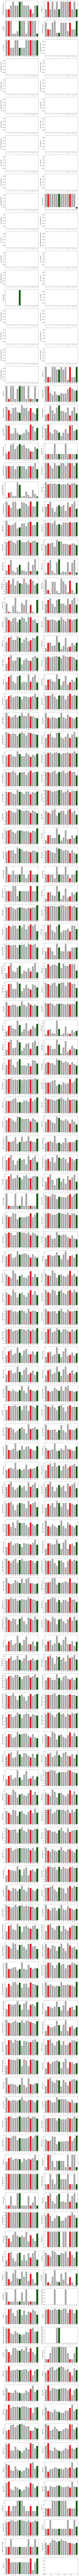

In [33]:
%%time
descriptive_bar_plot((categorical_cols + binary_cols + ordinal_cols), colors_clusters,figsize=(14, 512))

number of rows: 4


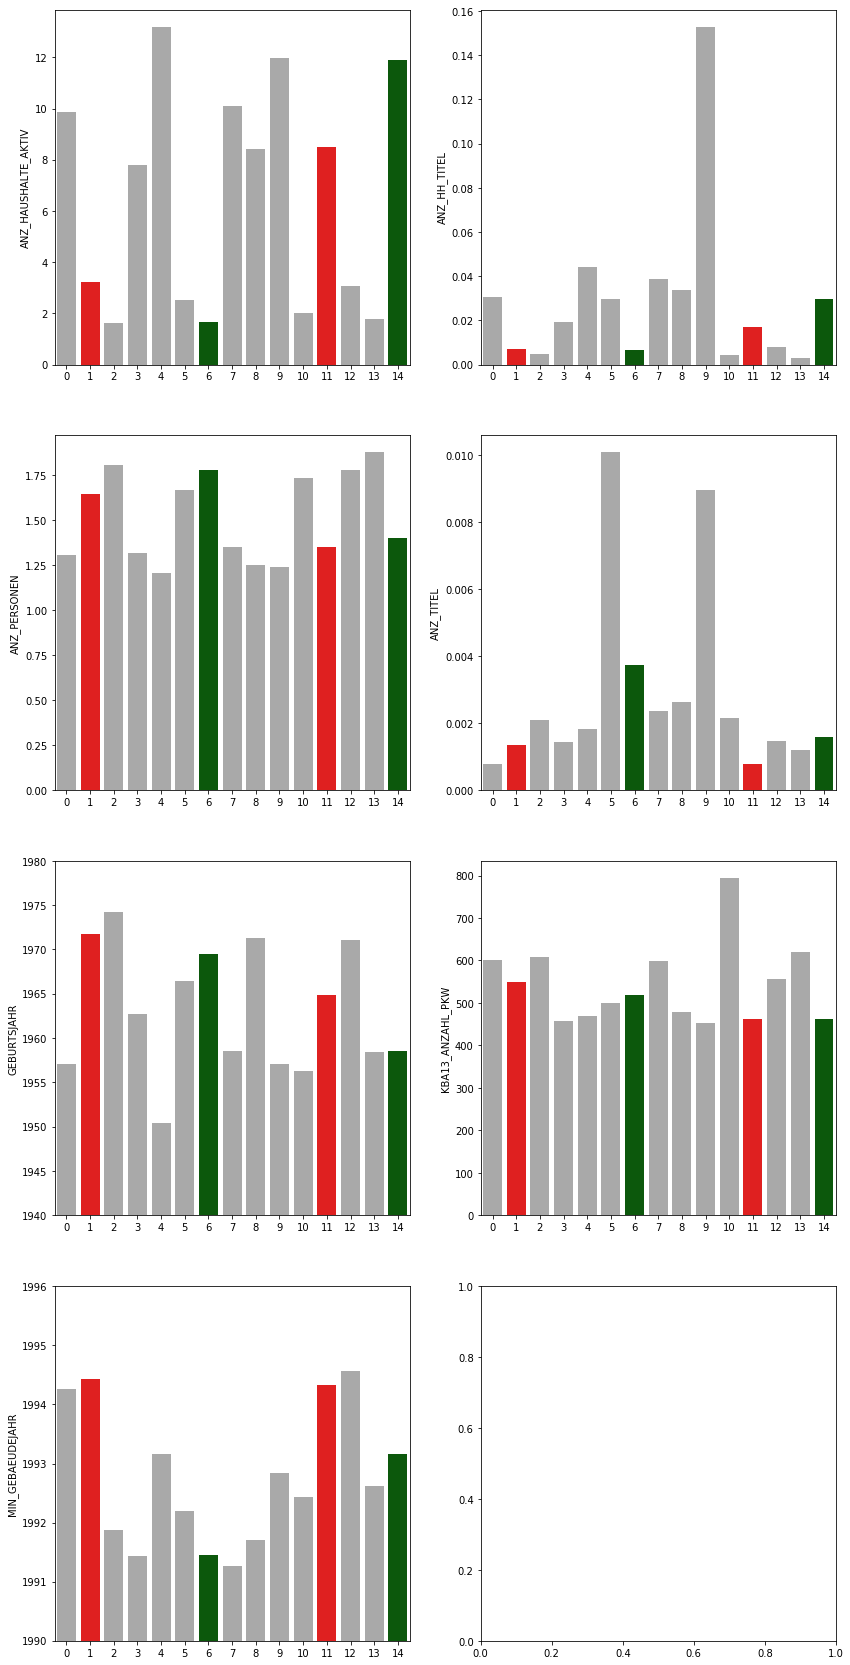

In [34]:
descriptive_bar_plot(numerical_cols, colors_clusters,figsize=(14, 30))

* Realize a priori selection of variables that have differences between them and can characterize each cluster

number of rows: 7


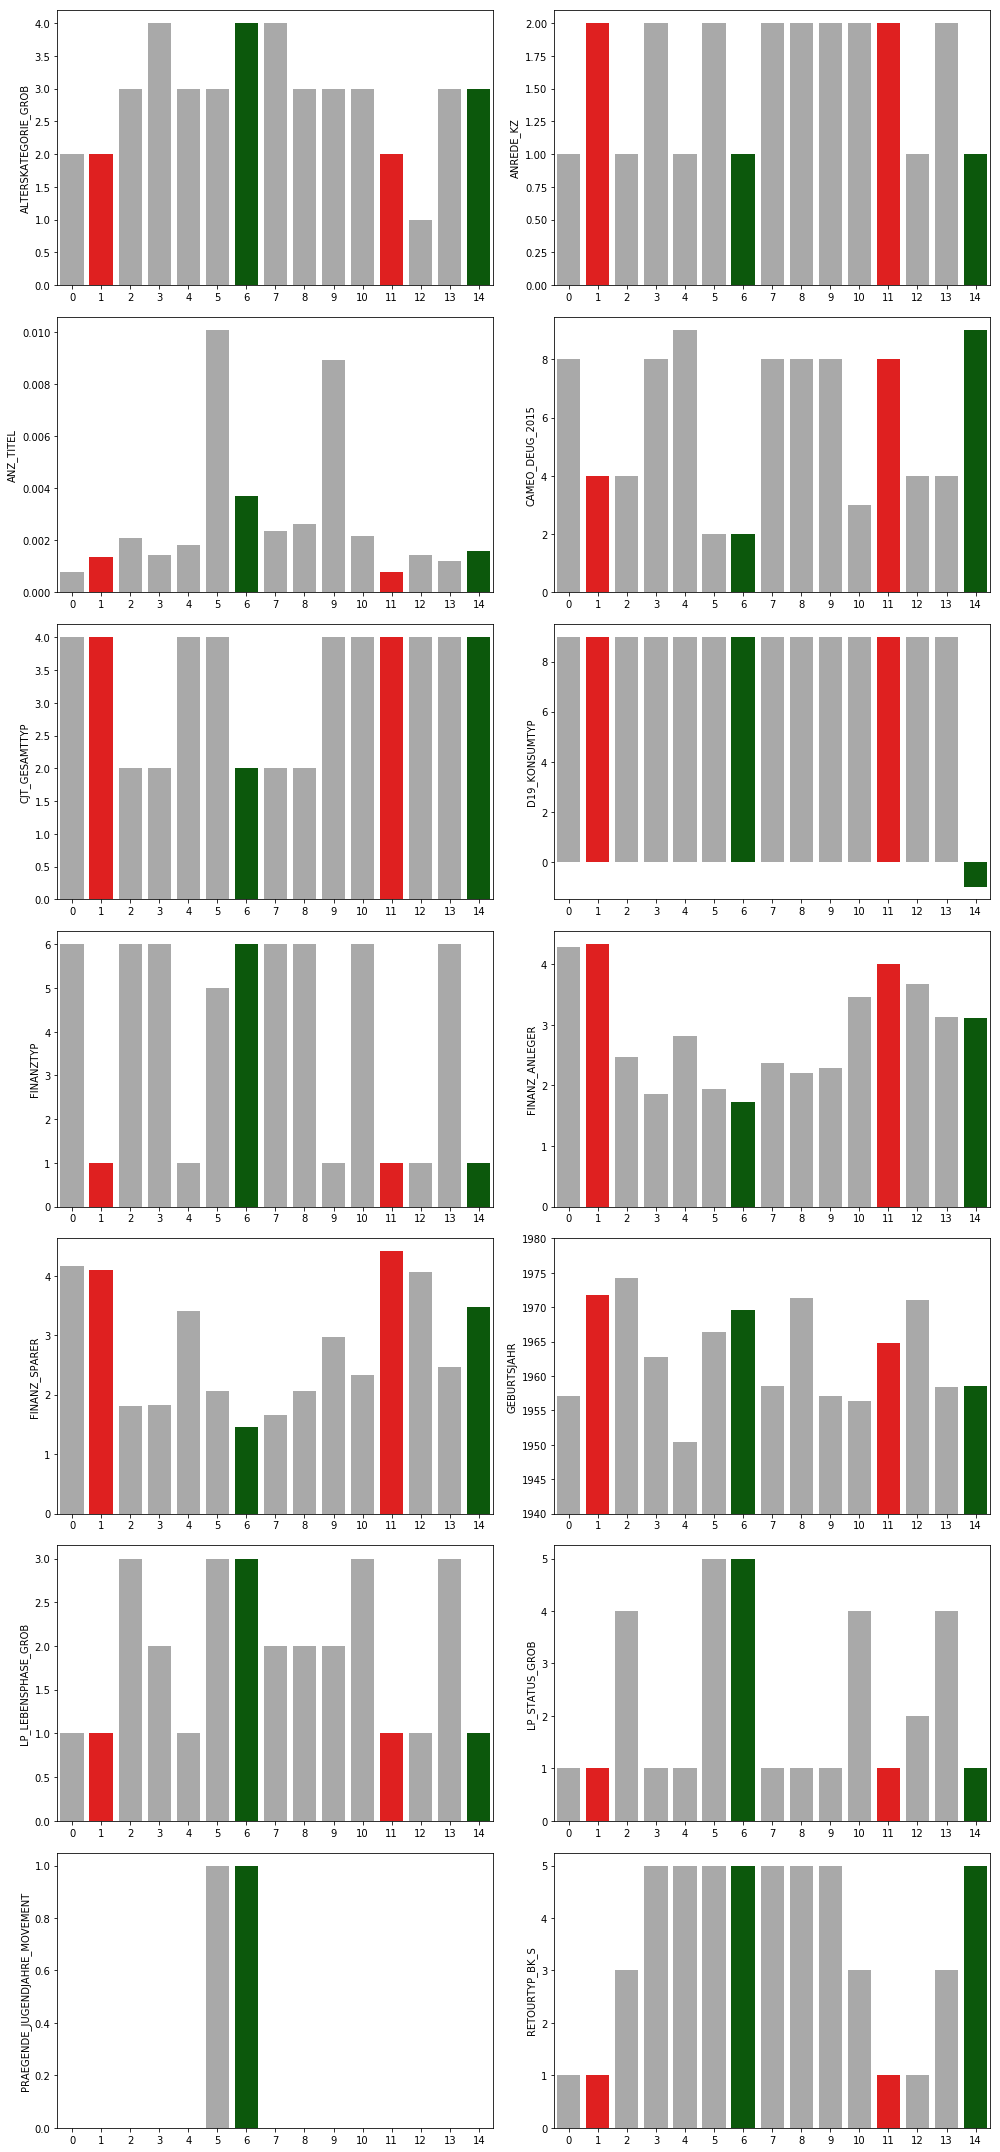

In [35]:
interest_columns = ['ALTERSKATEGORIE_GROB',
'ANREDE_KZ',
'ANZ_TITEL',
'CAMEO_DEUG_2015',
'CJT_GESAMTTYP',
'D19_KONSUMTYP',
'FINANZTYP',
'FINANZ_ANLEGER',
'FINANZ_SPARER',
'GEBURTSJAHR',
'LP_LEBENSPHASE_GROB',
'LP_STATUS_GROB',
'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
'RETOURTYP_BK_S']

nc = 2
nr = int(np.ceil(len(interest_columns)/nc))

print("number of rows: {}".format(nr))

fig, ax = plt.subplots(nr, nc, figsize=(14, 30))
axs = ax.flatten()
# 1-6 | 10-2
for i,c in enumerate(np.sort(interest_columns)):
#     print(c)
#     print(i)
    
    if 'MIN_GEBAEUDEJAHR' in c:
        axs[i].set_ylim(bottom=1990, top = 1996)
    elif 'GEBURTSJAHR' in c:
        axs[i].set_ylim(bottom=1940, top = 1980)
    sns.barplot(data=cluster_centers, x=cluster_centers.index.values, y= c, palette= colors_clusters, ax=axs[i])    
    pass

fig.tight_layout()
fig.savefig("Images/cluster_centers_columns_interest.png")

### over all the azdias dataset

in the previous graphs we identify some columns that differ between the two main groups identifyed earlier, so we will see how they behave within all the members of each cluster to see if the difference between them is mantained

In [36]:
%%time
azdias2 = stp_null.transform(azdias)
azdias2['cluster'] = train_preds

CPU times: user 2.48 s, sys: 27.3 s, total: 29.7 s
Wall time: 3min 20s


number of rows: 14


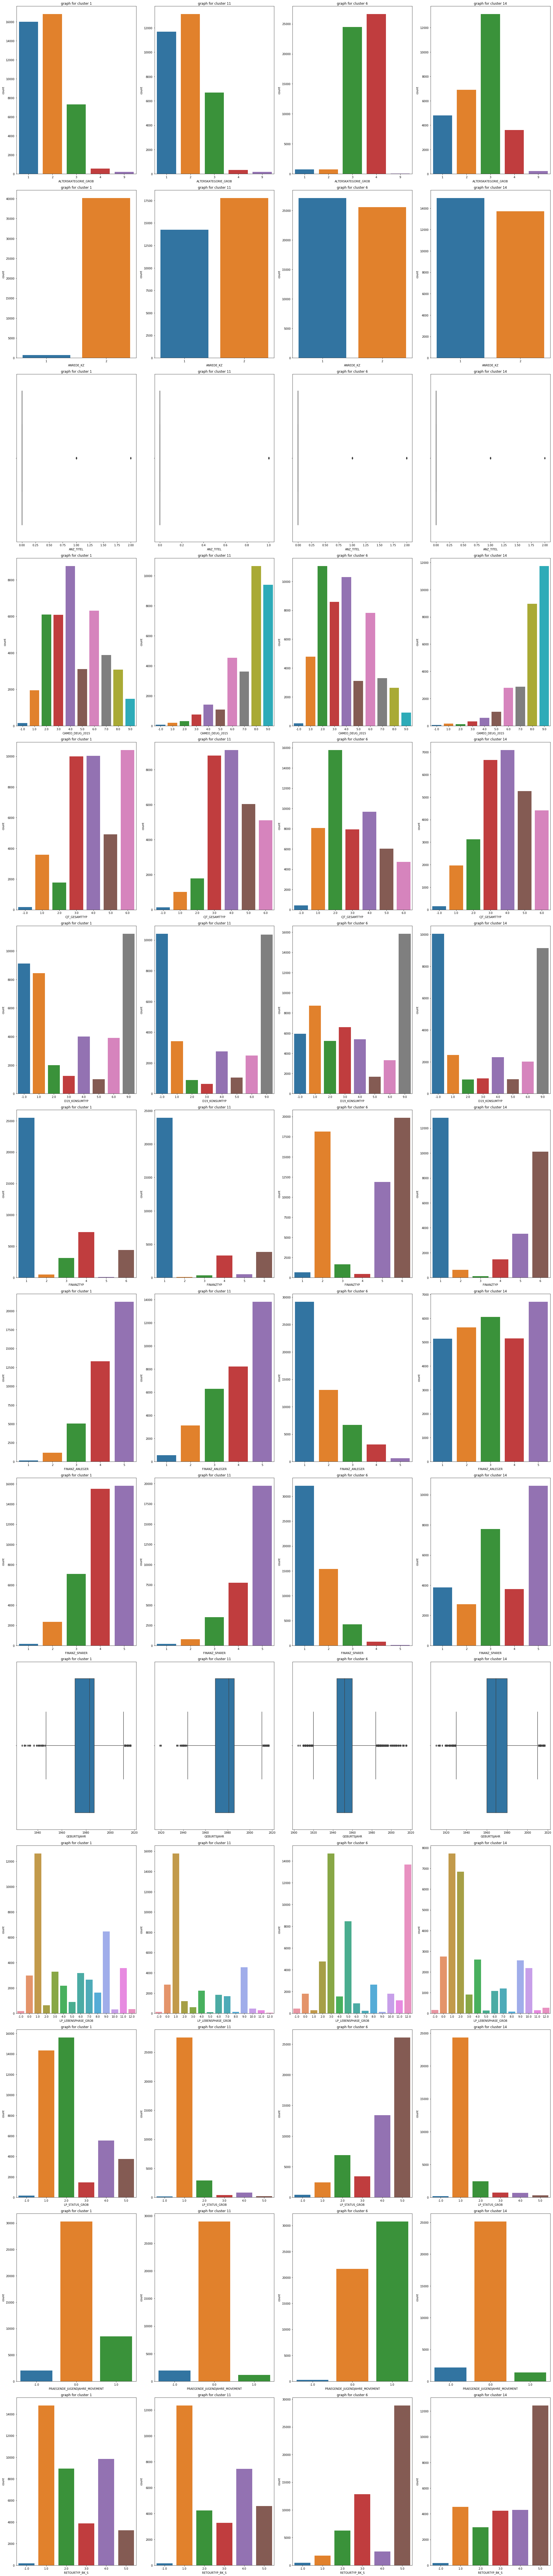

In [38]:
nc = 4
nr = len(interest_columns)

print("number of rows: {}".format(nr))

fig, ax = plt.subplots(nr, nc, figsize=(28, 130))
axs = ax.flatten()
# for i,c in enumerate(categorical_cols + binary_cols + ordinal_cols):
for i,c in enumerate(np.sort(interest_columns)):
    
    n1=1
    n2=11
    n3=6
    n4=14
    
    c1 = azdias2['cluster'] == n1
    c2 = azdias2['cluster'] == n2
    c3 = azdias2['cluster'] == n3
    c4 = azdias2['cluster'] == n4

    i1= i*nc+0
    i2= i*nc+1
    i3= i*nc+2
    i4= i*nc+3
    
    if c in numerical_cols:
        sns.boxplot(data=azdias2[c1], x= c, ax=axs[i1])
        axs[i1].set_title("graph for cluster {}".format(n1))
    
        sns.boxplot(data=azdias2[c2], x= c, ax=axs[i2])
        axs[i2].set_title("graph for cluster {}".format(n2))

        sns.boxplot(data=azdias2[c3], x= c, ax=axs[i3])
        axs[i3].set_title("graph for cluster {}".format(n3))
        
        sns.boxplot(data=azdias2[c4], x= c, ax=axs[i4])
        axs[i4].set_title("graph for cluster {}".format(n4))
        
    else:
        sns.countplot(data=azdias2[c1], x= c, ax=axs[i1])
        axs[i1].set_title("graph for cluster {}".format(n1))

        sns.countplot(data=azdias2[c2], x= c, ax=axs[i2])
        axs[i2].set_title("graph for cluster {}".format(n2))

        sns.countplot(data=azdias2[c3], x= c, ax=axs[i3])
        axs[i3].set_title("graph for cluster {}".format(n3))
        
        sns.countplot(data=azdias2[c4], x= c, ax=axs[i4])
        axs[i4].set_title("graph for cluster {}".format(n4))
    
    pass

fig.tight_layout()
fig.savefig("Images/descrition_of_customer_clusters.png")

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [5]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


> Check for the ammount of positive and negative cases

In [6]:
mailout_train["RESPONSE"].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

> Prepare Data

Start cleaning data
success: replacing AGER_TYP column keys to Nan
success: replacing ALTERSKATEGORIE_GROB column keys to Nan
success: replacing ALTER_HH column keys to Nan
success: replacing ANREDE_KZ column keys to Nan
success: replacing BALLRAUM column keys to Nan
success: replacing BIP_FLAG column keys to Nan
success: replacing CAMEO_DEUG_2015 column keys to Nan
success: replacing CAMEO_DEUINTL_2015 column keys to Nan
success: replacing CJT_GESAMTTYP column keys to Nan
success: replacing D19_BANKEN_ANZ_12 column keys to Nan
success: replacing D19_BANKEN_ANZ_24 column keys to Nan
success: replacing D19_BANKEN_DATUM column keys to Nan
success: replacing D19_BANKEN_DIREKT_ column keys to Nan
success: replacing D19_BANKEN_GROSS_ column keys to Nan
success: replacing D19_BANKEN_LOKAL_ column keys to Nan
success: replacing D19_BANKEN_OFFLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_QUOTE_12 column keys to 

success: replacing KBA13_MOTOR column keys to Nan
success: replacing KBA05_MOTRAD column keys to Nan
success: replacing KBA13_MOTRAD column keys to Nan
success: replacing KBA05_SEG1 column keys to Nan
success: replacing KBA13_SEG1 column keys to Nan
success: replacing KBA05_SEG10 column keys to Nan
success: replacing KBA13_SEG10 column keys to Nan
success: replacing KBA05_SEG2 column keys to Nan
success: replacing KBA13_SEG2 column keys to Nan
success: replacing KBA05_SEG3 column keys to Nan
success: replacing KBA13_SEG3 column keys to Nan
success: replacing KBA05_SEG4 column keys to Nan
success: replacing KBA13_SEG4 column keys to Nan
success: replacing KBA05_SEG5 column keys to Nan
success: replacing KBA13_SEG5 column keys to Nan
success: replacing KBA05_SEG6 column keys to Nan
success: replacing KBA13_SEG6 column keys to Nan
success: replacing KBA05_SEG7 column keys to Nan
success: replacing KBA13_SEG7 column keys to Nan
success: replacing KBA05_SEG8 column keys to Nan
success: repl

Dropping columns with high percetnage of missing values
ammount of dropped columns: 34
remaining columns: 333
END removing columns high percetnage of missing values

removing id cols

removing columns not avaliable in the data dictionary
ammount of dropped columns: 58
remaining columns: 275

removing redundat cols: ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN']
ammount of dropped columns: 4
remaining columns: 275

Start clenaing null rows
END clenaing null rows
End cleaning data

Start transforming data
START transforming CAMEO_DEUG_2015
END transforming CAMEO_DEUG_2015

START encoding OST_WEST_KZ column
END encoding OST_WEST_KZ column

START transforming PLZ8_BAUMAX
END transforming PLZ8_BAUMAX

START transforming PRAEGENDE_JUGENDJAHRE
END transforming PRAEGENDE_JUGENDJAHRE

START transforming WOHNLAGE
END transforming WOHNLAGE

End transforming data



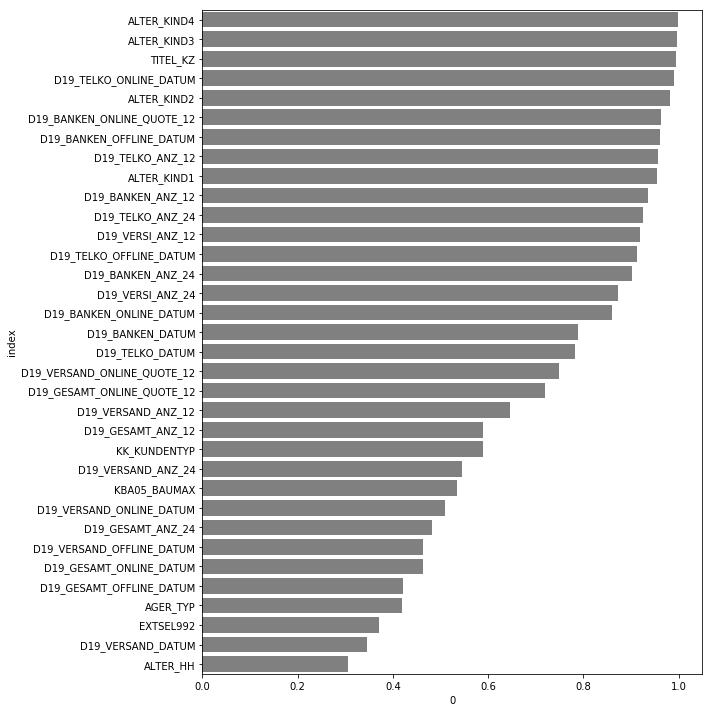

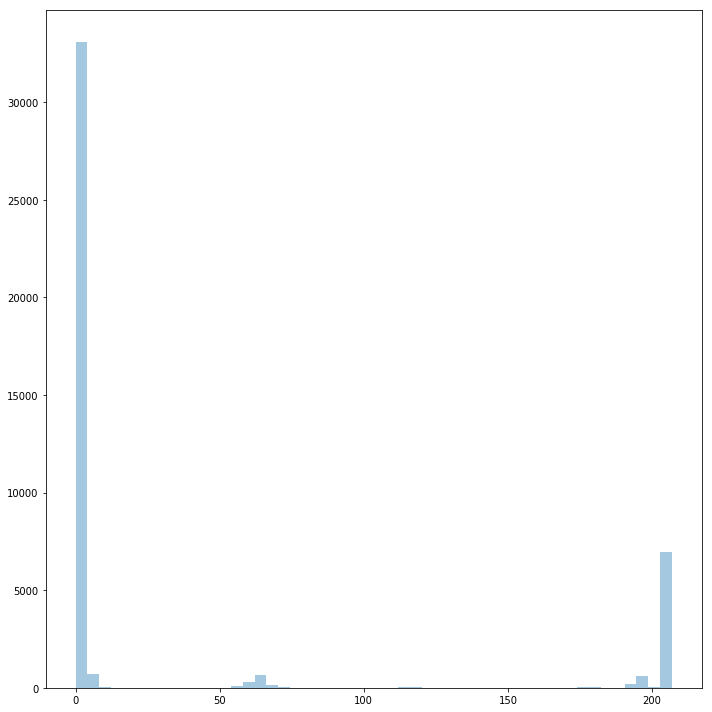

In [7]:
mailout_train = data_transform.clean_transform_data(mailout_train, train= True)
mailout_train.drop(columns=['D19_GESAMT_DATUM'],inplace= True)

y_train = mailout_train["RESPONSE"]
X_train = mailout_train.drop(["RESPONSE"], axis=1)

In [8]:
#columns validations
[x for x in X_train.columns.values if x not in azdias.columns.values]

[]

* This pipeline is created taking the previous unsupervised model fitted features

In [10]:
# Get all the transformers to go backwards

stp_kmeans = cluster_pipeline['kmeans']
stp_pca = cluster_pipeline['pca']
stp_transform = cluster_pipeline['transform']
stp_null = cluster_pipeline['null']

In [11]:
transform_pipeline = Pipeline([
        ('null',stp_null),
        ('transform', stp_transform)])

In [12]:
X_train_transformed = transform_pipeline.transform(X_train)

In [14]:
X_preds = cluster_pipeline.predict(X_train)
X_train2=np.append(X_train_transformed,np.atleast_2d(X_preds).T,axis=1)

array([ 9,  2, 10, ...,  2,  3,  6], dtype=int32)

In [17]:
models = {'RandomForestClassifier': RandomForestClassifier(random_state=42), 
          'AdaBoostClassifier': AdaBoostClassifier(random_state=42), 
          'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)
         }

RandomForestClassifier
RandomForestClassifier(random_state=42)
Roc_auc train score = 1.0
Roc_auc validation score = 0.4785



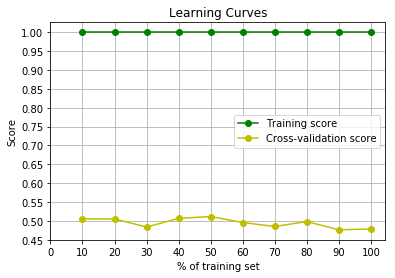

AdaBoostClassifier
AdaBoostClassifier(random_state=42)
Roc_auc train score = 0.8301
Roc_auc validation score = 0.5328



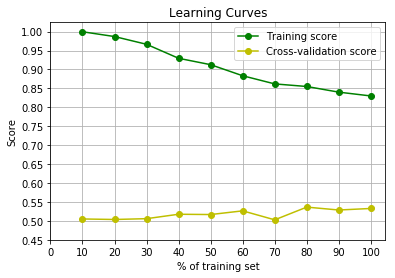

GradientBoostingClassifier
GradientBoostingClassifier(random_state=42)


In [ ]:
%%time

num_trainings = 10
for k,m in models.items():
    print(k)
    print(m)
  
    
    train_sizes, train_scores, test_scores = learning_curve(
    m, X_train_transformed, y_train, cv=None, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, num_trainings),
    verbose=3, n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print("Roc_auc train score = {}".format(train_scores_mean[-1].round(4)))
    print("Roc_auc validation score = {}".format(test_scores_mean[-1].round(4)))
    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("% of training set")
    plt.ylabel("Score")

    plt.plot(np.linspace(.1, 1.0, num_trainings)*100, train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(np.linspace(.1, 1.0, num_trainings)*100, test_scores_mean, 'o-', color="y",
             label="Cross-validation score")

    plt.yticks(np.arange(0.45, 1.02, 0.05))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend(loc="best")
    print("")
    plt.show()
    plt.savefig("Images/LC_{}2.png".format(k))

#### Perform Grid Search to find best parameters

In [ ]:
#initialize pipeline with GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=42)

parameters = {'learning_rate': [0.1, 0.01], 'n_estimators': [100,150], 
              'max_depth': [3], 'min_samples_split': [2]}
        
        
grid_obj = GridSearchCV(gbc, parameters, scoring = 'roc_auc',verbose=3)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train_transformed, y_train)

# Get the estimator and predict
print(grid_obj.best_params_)
best_clf = grid_obj.best_estimator_
best_predictions = best_clf.predict_proba(X_train_transformed)[:, 1]

# Make predictions using unoptimized and the best model
predictions = (gbc.fit(X_train_transformed, y_train)).predict_proba(X_train_transformed)[:, 1]

print("Roc_auc score on training data: {:.4f}".format(roc_auc_score(y_train, predictions)))
print("Final Roc_auc score on the training data: {:.4f}".format(roc_auc_score(y_train, best_predictions)))

In [ ]:
pkl_filename = "Model/supervised_best_model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(best_clf, file)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [73]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Preparation

In [96]:
X_test = data_transform.clean_transform_data(mailout_test, train= False)
X_test.drop(columns=['D19_GESAMT_DATUM'],inplace=True)

Start cleaning data
success: replacing AGER_TYP column keys to Nan
success: replacing ALTERSKATEGORIE_GROB column keys to Nan
success: replacing ALTER_HH column keys to Nan
success: replacing ANREDE_KZ column keys to Nan
success: replacing BALLRAUM column keys to Nan
success: replacing BIP_FLAG column keys to Nan
success: replacing CAMEO_DEUG_2015 column keys to Nan
success: replacing CAMEO_DEUINTL_2015 column keys to Nan
success: replacing CJT_GESAMTTYP column keys to Nan
success: replacing D19_BANKEN_ANZ_12 column keys to Nan
success: replacing D19_BANKEN_ANZ_24 column keys to Nan
success: replacing D19_BANKEN_DATUM column keys to Nan
success: replacing D19_BANKEN_DIREKT_ column keys to Nan
success: replacing D19_BANKEN_GROSS_ column keys to Nan
success: replacing D19_BANKEN_LOKAL_ column keys to Nan
success: replacing D19_BANKEN_OFFLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_QUOTE_12 column keys to 

success: replacing KBA13_BJ_2006 column keys to Nan
success: replacing KBA13_BJ_2008 column keys to Nan
success: replacing KBA13_BJ_2009 column keys to Nan
success: replacing KBA13_BMW column keys to Nan
success: replacing KBA13_CCM_1000 column keys to Nan
success: replacing KBA13_CCM_1200 column keys to Nan
success: replacing KBA13_CCM_1400 column keys to Nan
success: replacing KBA13_CCM_0_1400 column keys to Nan
success: replacing KBA13_CCM_1500 column keys to Nan
success: replacing KBA13_CCM_1400_2500 column keys to Nan
success: replacing KBA13_CCM_1600 column keys to Nan
success: replacing KBA13_CCM_1800 column keys to Nan
success: replacing KBA13_CCM_2000 column keys to Nan
success: replacing KBA13_CCM_2500 column keys to Nan
success: replacing KBA13_CCM_2501 column keys to Nan
success: replacing KBA13_CCM_3000 column keys to Nan
success: replacing KBA13_CCM_3001 column keys to Nan
success: replacing KBA13_FAB_ASIEN column keys to Nan
success: replacing KBA13_FAB_SONSTIGE column k

In [97]:
pkl_filename = "Model/unsupervised_cluster_model.pkl"  
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file)
    
cluster_pipeline = pickle_model

In [98]:
stp_kmeans = cluster_pipeline['kmeans']
stp_pca = cluster_pipeline['pca']
stp_transform = cluster_pipeline['transform']
stp_null = cluster_pipeline['null']

In [99]:
transform_pipeline = Pipeline([
        ('null',stp_null),
        ('transform', stp_transform)])

In [100]:
X_test = transform_pipeline.transform(X_test)

In [104]:
pkl_filename = "Model/supervised_best_model.pkl"  
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file)
    
prediction_model = pickle_model

In [105]:
y = prediction_model.predict_proba(X_test)[:, 1]

In [111]:
mailout_test['RESPONSE'] = y
mailout_test[['LNR','RESPONSE']].to_csv('Model/test_prediction.csv',index=False)

# Article Link
[article](https://paulguzcas984.medium.com/customer-segmentation-report-for-arvato-financial-services-b44979683ed)